# Prédiction d'éligibilité pour un crédit chez une Banque

### Contexte du projet
**Vous travaillez pour une banque qui souhaite implémenter un système de scoring de crédit basé sur des données clients anonymisées. Ce modèle permet d'évaluer la probabilité de remboursement et de minimiser les risques tout en maximisant les profits. Les données incluent des caractéristiques financières et personnelles ainsi que des historiques de remboursement.**

### Phase 1. Veille et exploration théorique

**Objectif** : Comprendre les concepts clés de la validation croisée (cross-validation), de l'optimisation d'hyperparamètres (GridSearchCV et RandomizedSearchCV).

#### Choose Validation Scheme
Choose a validation method to examine the predictive accuracy of the fitted models. Validation estimates model performance on new data compared to the training data, and helps you choose the best model. Validation protects against overfitting. Choose a validation scheme before training any models, so that you can compare all the models in your session using the same validation scheme.

##### Cross-Validation: 
Select a number of folds (or divisions) to partition the data set using the slider control.

1. If you choose $k$ folds, then the app: Partitions the data into $k$ disjoint sets or folds

2. For each fold: Trains a model using the out-of-fold observations
 * Assesses model performance using in-fold data
 * Calculates the average test error over all folds

This method gives a good estimate of the predictive accuracy of the final model trained with all the data. It requires multiple fits but makes efficient use of all the data, so it is recommended for small data sets.

###### Holdout Validation: 
Select a percentage of the data to use as a test set using the slider control. The app trains a model on the training set and assesses its performance with the test set. The model used for validation is based on only a portion of the data, so Holdout Validation is recommended only for large data sets. The final model is trained with the full data set.

###### No Validation: 
No protection against overfitting. The app uses all of the data for training and computes the error rate on the same data. Without any test data, you get an unrealistic estimate of the model’s performance on new data. That is, the training sample accuracy is likely to be unrealistically high, and the predictive accuracy is likely to be lower.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

### Phase 2. Compréhension et exploration des données

**Objectif** : Examiner la structure et les caractéristiques principales des données.

In [92]:
# Get the current working directory
current_directory = os.getcwd()

# Correctly join the path to the data file, relative to the script's location
file_path = os.path.join(current_directory, "../data", "loan-data.csv")

# Define the data types for each column
dtypes = {
    "Loan_ID": str,
    "Gender": "category",
    "Married": "category",
    "Dependents": "category",
    "Education": "category",
    "Self_Employed": "category",
    "ApplicantIncome": float,
    "CoapplicantIncome": float,
    "LoanAmount": float,
    "Loan_Amount_Term": float,
    "Credit_History": float,
    "Property_Area": "category",
    "Loan_Status": "object"
}

# Read the CSV file into a DataFrame
loandata = pd.read_csv(file_path, dtype=dtypes)
d,h=loandata.shape
print('Initial data set has',d,' lines')



Initial data set has 981  lines


In [93]:
# Remove duplicates if any
loandata = loandata.drop_duplicates() 
# Optional: Reset index if needed 
loandata = loandata.drop_duplicates(subset=['Loan_ID'])
dou,h=loandata.shape
print('Initial data set had',d-dou,' duplicates')

Initial data set had 0  duplicates


In [94]:
# Handle the 'Loan_ID' formatting (trimming non-numeric characters and handling thousands separator)
loandata['Loan_ID'] = loandata['Loan_ID'].str.replace(r'\D', '', regex=True)  # Remove non-numeric characters
loandata['Dependents'] = loandata['Dependents'].replace('3+', '3')
loandata['Dependents'] = loandata['Dependents'].astype(float)

In [95]:
valid_loandata = loandata.dropna(subset=['Loan_Status'])
# Calculate medians 
loan_amount_median = valid_loandata['LoanAmount'].median() 
loan_amount_term_median = valid_loandata['Loan_Amount_Term'].median() 

print(f"Median LoanAmount: {loan_amount_median}") 
print(f"Median Loan_Amount_Term: {loan_amount_term_median}") 

# Fill the missing values in the LoanAmount column with the median value
loandata['LoanAmount'].fillna(loan_amount_median, inplace=True)
loandata['Loan_Amount_Term'].fillna(loan_amount_term_median, inplace=True)

# Convert Credit_History to integers 
loandata['Loan_Status'].fillna('-1', inplace=True)
loandata['Loan_Status'] = loandata['Loan_Status'].astype('category')
loandata['Loan_Status'].value_counts()


loandata['Credit_History'].value_counts()

Median LoanAmount: 128.0
Median Loan_Amount_Term: 360.0


Credit_History
1.0    754
0.0    148
Name: count, dtype: int64

In [96]:
from scipy.stats import chi2_contingency

# Replace 'Y' and 'N' with numeric values for Loan_Status 
loandata['Loan_Status'] = loandata['Loan_Status'].map({'Y': 1, 'N': 0, '-1':-1}) 
# Create contingency table 
contingency_table = pd.crosstab(loandata['Credit_History'], loandata['Loan_Status']) 
print("Contingency Table:") 
print(contingency_table) 
# Perform chi-square test 
chi2, p, dof, expected = chi2_contingency(contingency_table) 
print(f"Chi-square statistic: {chi2}") 
print(f"p-value: {p}") 
print(f"Degrees of freedom: {dof}") 
print("Expected frequencies:") 
print(expected)

Contingency Table:
Loan_Status      -1   0    1
Credit_History              
0.0              59  82    7
1.0             279  97  378
Chi-square statistic: 172.8414277284597
p-value: 2.9373848230992693e-38
Degrees of freedom: 2
Expected frequencies:
[[ 55.45898004  29.37028825  63.17073171]
 [282.54101996 149.62971175 321.82926829]]


In [97]:
loandata.loc[(loandata['Loan_Status'] == 0) & (loandata['Credit_History'].isna()), 'Credit_History'] = 0
loandata['Credit_History'].value_counts()

Credit_History
1.0    754
0.0    161
Name: count, dtype: int64

In [98]:
#One-month Loan amount for applicant and coaplicant

loandata = loandata[loandata['LoanAmount'].notna()]
d1,h = loandata.shape 
dd1=(1-d1/d)*100
print('\nlost ',dd1,'% of the data')


loandata = loandata[loandata['Loan_Amount_Term'].notna()]  
loandata['LoanAmount'] = loandata['LoanAmount'] * 1000

loandata['Loan_Per_Month'] = loandata['LoanAmount']/loandata['Loan_Amount_Term']
loandata['ApplicantIncome_Per_Month']= loandata['ApplicantIncome']/12
loandata['CoapplicantIncome_Per_Month']= loandata['CoapplicantIncome']/12

d2,h = loandata.shape 
dd2=(1-d2/d)*100
print(d2)
print('lost ',dd2,'% of the data')


lost  0.0 % of the data
981
lost  0.0 % of the data


In [99]:
loandata['Credit_History']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
976    1.0
977    1.0
978    NaN
979    1.0
980    1.0
Name: Credit_History, Length: 981, dtype: float64

## Handle missing data for categorical columns

In [100]:
# Handle missing data for categorical columns by filling empty fields with the most frequent value
categorical_columns = ["Gender", "Married", "Education",'Dependents', "Self_Employed", "Property_Area"]

for col in categorical_columns:
    # Find the most frequent value (mode) in the column
    most_frequent = loandata[col].mode()[0]
    # Fill missing values with the most frequent value
    loandata[col].fillna(most_frequent, inplace=True)

# Check if the missing values are filled
for col in categorical_columns:
    print(f"Missing values in {col}: {loandata[col].isna().sum()}")


Missing values in Gender: 0
Missing values in Married: 0
Missing values in Education: 0
Missing values in Dependents: 0
Missing values in Self_Employed: 0
Missing values in Property_Area: 0


In [118]:
# Separate the data into two DataFrames
loan_status_Y_N = loandata[loandata['Loan_Status'].isin([1, 0])]
#loan_status_rest = loandata[~loandata['Loan_Status'].isin(['1', '0','-1'])]

loandataYN=loan_status_Y_N.copy()
# Display the first few rows of each DataFrame
print("Loan Status 'Y' or 'N':")
loandataYN.tail()

Loan Status 'Y' or 'N':


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Per_Month,ApplicantIncome_Per_Month,CoapplicantIncome_Per_Month
609,002978,Female,No,0.0,Graduate,No,2900.0,0.0,71000.0,360.0,1.0,Rural,1,197.222222,241.666667,0.0
610,002979,Male,Yes,3.0,Graduate,No,4106.0,0.0,40000.0,180.0,1.0,Rural,1,222.222222,342.166667,0.0
611,002983,Male,Yes,1.0,Graduate,No,8072.0,240.0,253000.0,360.0,1.0,Urban,1,702.777778,672.666667,20.0
612,002984,Male,Yes,2.0,Graduate,No,7583.0,0.0,187000.0,360.0,1.0,Urban,1,519.444444,631.916667,0.0
613,002990,Female,No,0.0,Graduate,Yes,4583.0,0.0,133000.0,360.0,0.0,Semiurban,0,369.444444,381.916667,0.0


In [119]:
d3,h=loandataYN.shape
print(d3)
deleted_percentage = (1-d3 / d) * 100
print(f"It was deleted {deleted_percentage:.2f}% of data")

614
It was deleted 37.41% of data


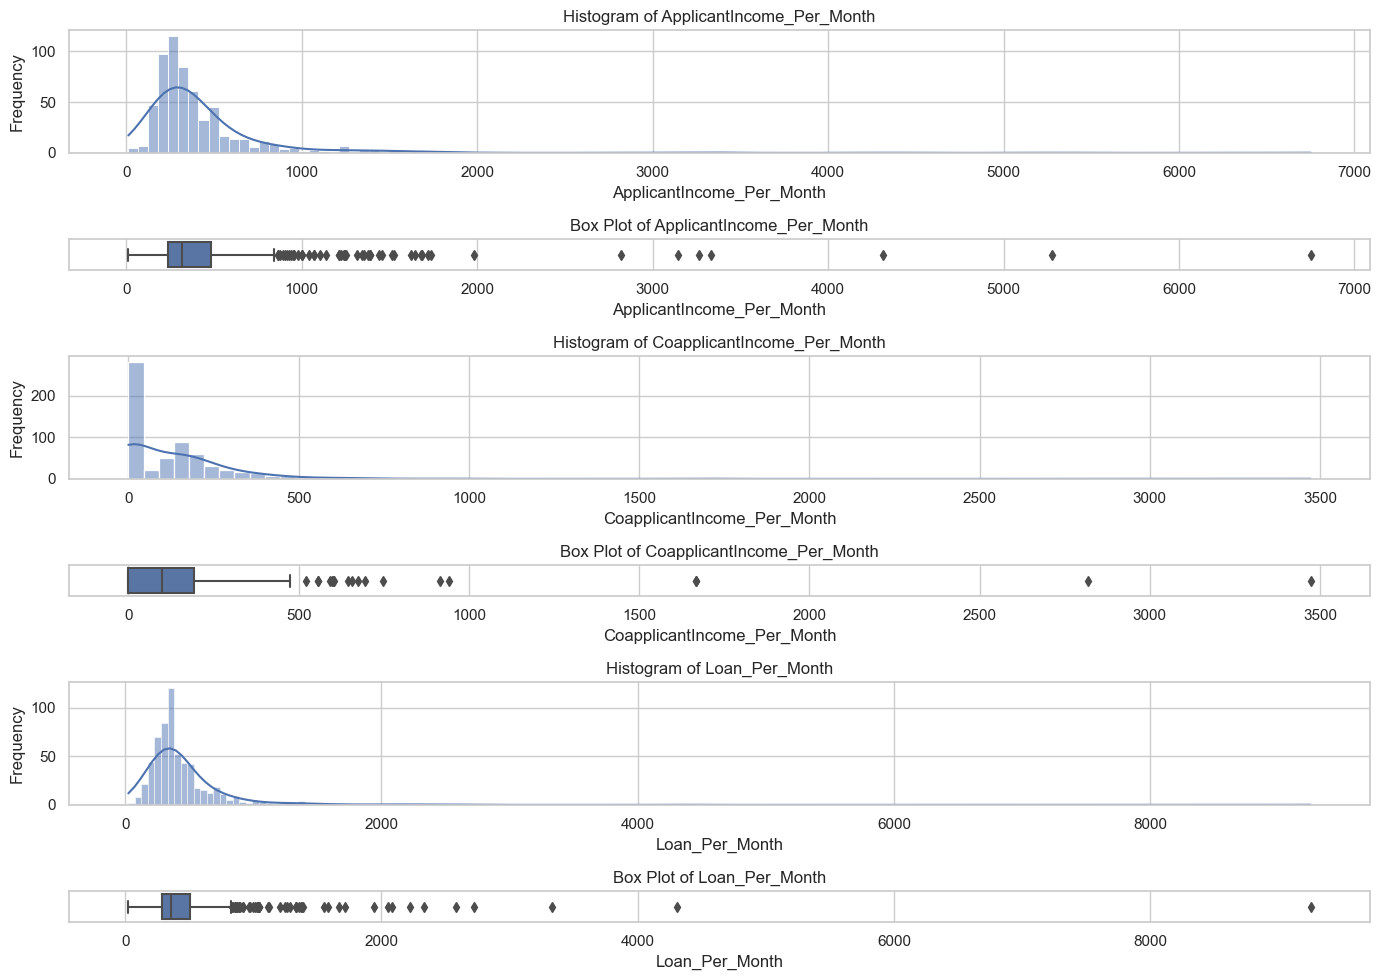

In [120]:
# Define the numerical columns
numerical_columns = ['ApplicantIncome_Per_Month', 
                     'CoapplicantIncome_Per_Month',
                     'Loan_Per_Month']

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(10, 1, height_ratios=[4, 1] * 5)  # [4, 1] ratio for each pair

for i, col in enumerate(numerical_columns):
    # Histogram subplot
    ax_hist = fig.add_subplot(gs[i*2])
    sns.histplot(loandataYN[col], kde=True, ax=ax_hist)
    ax_hist.set_title(f'Histogram of {col}')
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel('Frequency')
    
    # Box plot subplot
    ax_box = fig.add_subplot(gs[i*2 + 1])
    sns.boxplot(x=loandataYN[col], ax=ax_box)
    ax_box.set_title(f'Box Plot of {col}')
    ax_box.set_xlabel(col)

# Adjust layout for plots
plt.tight_layout()
plt.show()



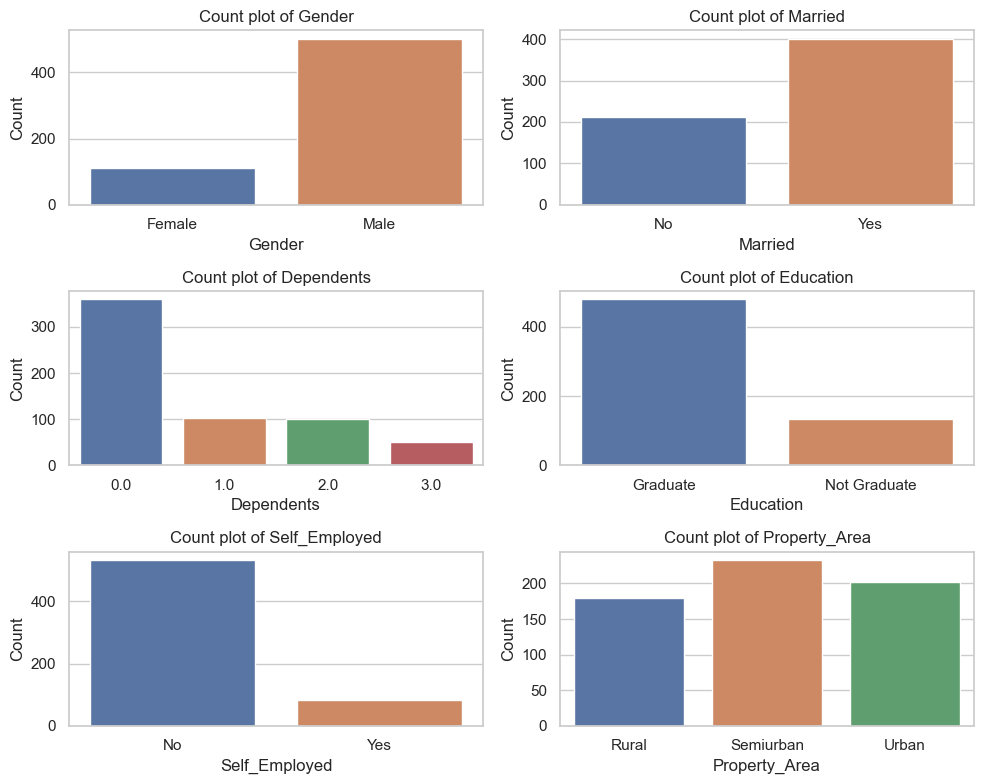

In [121]:
# Set the style of the plots
sns.set(style="whitegrid")

# --- Plot 2: Categorical Variables ---
# Create subplots for categorical variables (4 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for i, col in enumerate(categorical_columns):
    ax = axes[i//2, i%2]  # Calculate the correct position for the subplot
    sns.countplot(x=loandataYN[col], ax=ax)
    ax.set_title(f'Count plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Adjust layout for categorical plots
plt.tight_layout()
plt.show()

### Phase 3. Prétraitement des données

**Objectif** : Nettoyer et transformer les données pour préparer un jeu propre et utilisable. Identifier les données qui vous serviront à prédire l'éligibilité des clients aux crédits et qui ne sont pas à inclure dans les données d'entrainements et de test.

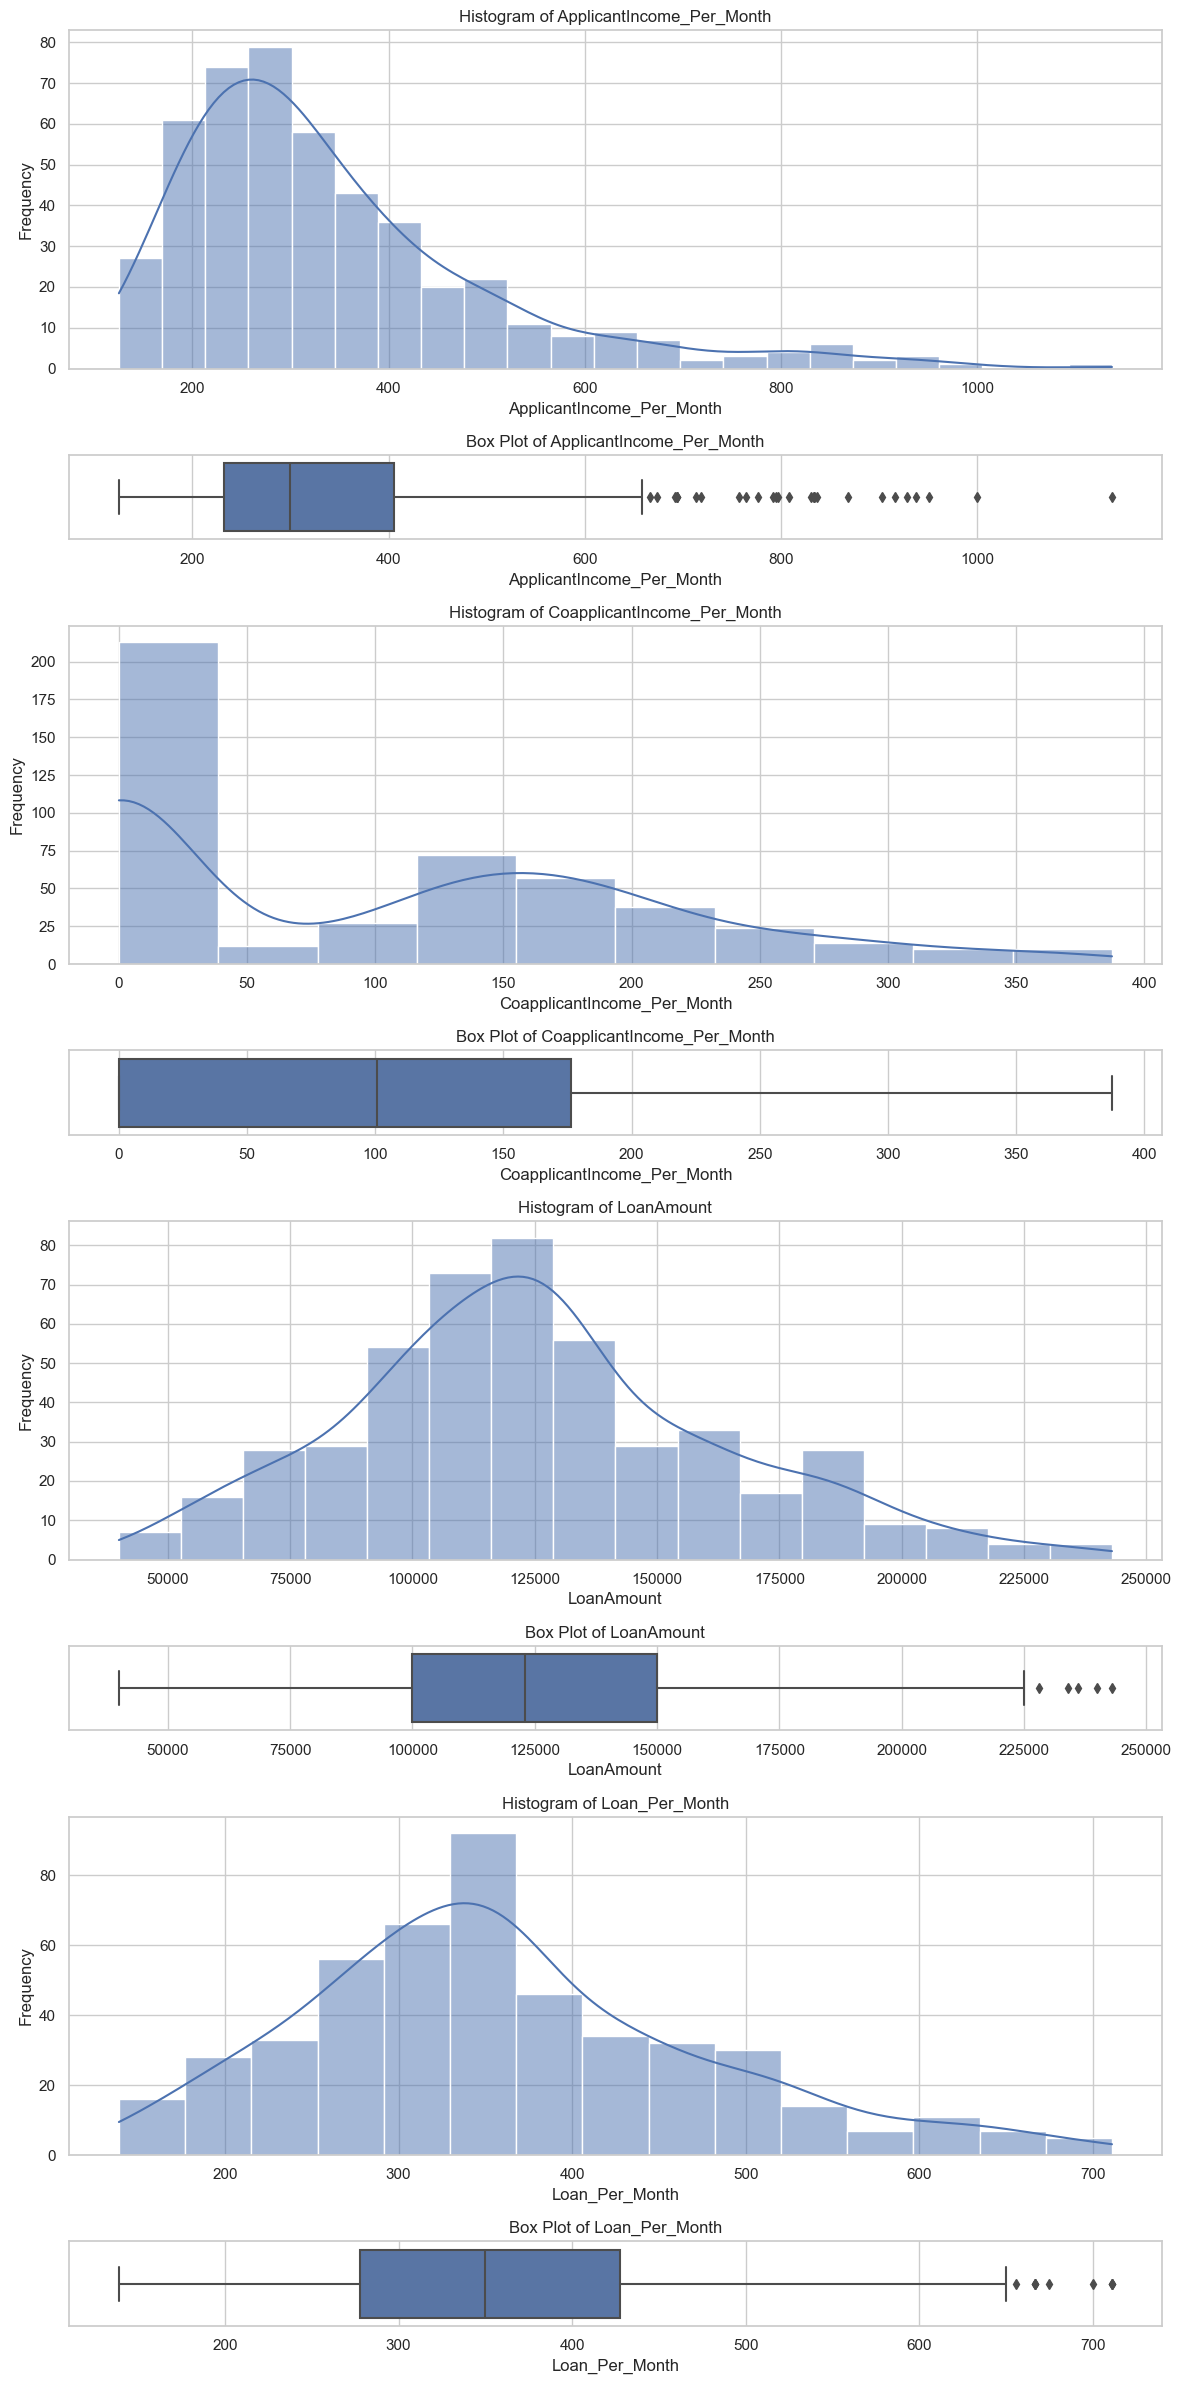

In [122]:
# Define the numerical columns
numerical_columns = ['ApplicantIncome_Per_Month', 
                     'CoapplicantIncome_Per_Month', 
                     'LoanAmount', 
                     'Loan_Per_Month']


# Define a function to remove outliers
def remove_outliers(df, columns, lower_quantile=0.015, upper_quantile=0.95):
    for col in columns:
        lower_limit = df[col].quantile(lower_quantile)
        upper_limit = df[col].quantile(upper_quantile)
        df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]
    return df

# Apply the function to remove outliers
loandataYN = remove_outliers(loandataYN, numerical_columns)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(12, 24))
gs = gridspec.GridSpec(8, 1, height_ratios=[4, 1] * 4)  # [4, 1] ratio for each pair

for i, col in enumerate(numerical_columns):
    # Histogram subplot
    ax_hist = fig.add_subplot(gs[i*2])
    sns.histplot(loandataYN[col], kde=True, ax=ax_hist)
    ax_hist.set_title(f'Histogram of {col}')
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel('Frequency')
    
    # Box plot subplot
    ax_box = fig.add_subplot(gs[i*2 + 1])
    sns.boxplot(x=loandataYN[col], ax=ax_box)
    ax_box.set_title(f'Box Plot of {col}')
    ax_box.set_xlabel(col)

# Adjust layout for plots
plt.tight_layout()
plt.show()

In [123]:
d4,h=loandataYN.shape
print(d4)
deleted_percentage = (1 - d4 / d) * 100
print(f"It was deleted {deleted_percentage:.2f}% of data")

477
It was deleted 51.38% of data


### Phase 4 : Entraînement et optimisation des modèles : 

**Objectif** : Tester plusieurs algorithmes de classification et optimiser leurs hyperparamètres.

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [125]:
coll=loandataYN.columns
loandataYN = loandataYN.dropna(subset=['Credit_History'])
loandataYN[coll].isna().sum()


Loan_ID                        0
Gender                         0
Married                        0
Dependents                     0
Education                      0
Self_Employed                  0
ApplicantIncome                0
CoapplicantIncome              0
LoanAmount                     0
Loan_Amount_Term               0
Credit_History                 0
Property_Area                  0
Loan_Status                    0
Loan_Per_Month                 0
ApplicantIncome_Per_Month      0
CoapplicantIncome_Per_Month    0
dtype: int64

In [126]:
#loandata_clean.shape
loandata_clean=loandataYN[['Gender', 'Married', 'Dependents','Self_Employed',
                           'Credit_History', 'Property_Area', 'Loan_Status',
                           'Loan_Per_Month','ApplicantIncome_Per_Month', 
                           'CoapplicantIncome_Per_Month']]


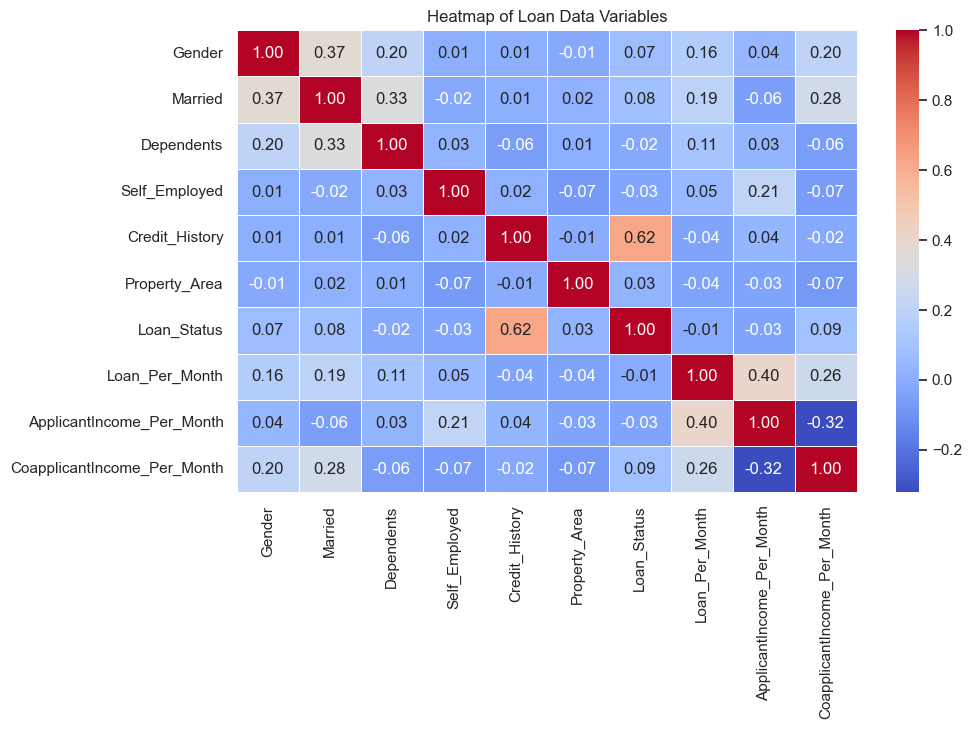

In [127]:
# Преобразование категориальных переменных в числовые
categorical_columns = ["Gender", "Married", "Dependents", "Property_Area", "Loan_Status", "Credit_History"]

for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Property_Area', 'Loan_Status']:
    loandata_clean.loc[:, col] = loandata_clean[col].astype('category').cat.codes

# Heat map
corr_matrix = loandata_clean.corr()

# Создаем тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Loan Data Variables')
plt.show()

**Next section refers to the common practice in data science of separating the dataset into features (independent variables) and the target variable (dependent variable) for the purpose of training and testing machine learning models.**

In [128]:
X = loandata_clean.drop('Loan_Status', axis=1)
y = loandata_clean['Loan_Status']
X = pd.get_dummies(X, drop_first=True)

In [129]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_val_pred = log_reg.predict(X_val_scaled)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.8777777777777778

Validation Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.62      0.77        29
           2       0.85      1.00      0.92        61

    accuracy                           0.88        90
   macro avg       0.92      0.81      0.84        90
weighted avg       0.90      0.88      0.87        90


Validation Confusion Matrix:
 [[18 11]
 [ 0 61]]


### Phase 5 : Évaluation et interprétation

**Objectif** : Évaluer la performance des modèles, analyser l'importance des caractéristiques et interpréter les résultats

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the categorical columns
categorical_columns = ["Gender", "Married", "Dependents", 'Loan_Per_Month', 'ApplicantIncome_Per_Month',
                       'CoapplicantIncome_Per_Month', "Self_Employed", "Property_Area", "Loan_Status", "Credit_History"]

# Convert the categorical columns to category type and then to codes
for col in categorical_columns:
    loandata_clean.loc[:, col] = loandata_clean[col].astype('category')
for col in categorical_columns:
    loandata_clean.loc[:, col] = loandata_clean[col].cat.codes

# Define features (X) and target (y)
X = loandata_clean.drop('Loan_Status', axis=1)
y = loandata_clean['Loan_Status']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results
print(f"Model Accuracy: {accuracy}")

print("Classification Report:\n", class_report)
print("Loan Approval Probabilities for the first 10 rows of the test set:\n", y_pred_proba[:10])


Model Accuracy: 0.8666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.54      0.68        24
           1       0.86      0.98      0.92        66

    accuracy                           0.87        90
   macro avg       0.89      0.76      0.80        90
weighted avg       0.87      0.87      0.85        90

Loan Approval Probabilities for the first 10 rows of the test set:
 [0.73605887 0.08018738 0.79607535 0.77981196 0.08284183 0.78820109
 0.13769612 0.84181023 0.88337857 0.81569785]


## Hyperparameters

In [131]:

# Assuming loandata_clean is your initial DataFrame
# Define the categorical columns
categorical_columns = ["Gender", "Married", "Dependents", 'Loan_Per_Month', 'ApplicantIncome_Per_Month',
                       'CoapplicantIncome_Per_Month', "Self_Employed", "Property_Area", "Loan_Status", "Credit_History"]

# Convert the categorical columns to category type and then to codes
for col in categorical_columns:
    loandata_clean.loc[:, col] = loandata_clean[col].astype('category')
for col in categorical_columns:
    loandata_clean.loc[:, col] = loandata_clean[col].cat.codes

# Define features (X) and target (y)
X = loandata_clean.drop('Loan_Status', axis=1)
y = loandata_clean['Loan_Status']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train logistic regression model with best parameters
best_logreg = LogisticRegression(C=1, max_iter=100, penalty='l1', solver='liblinear', random_state=42)
best_logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = best_logreg.predict(X_test)
y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results
print(f"Model Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Loan Approval Probabilities for the first 10 rows of the test set:\n", y_pred_proba[:10])


Model Accuracy: 0.8666666666666667
Confusion Matrix:
 [[13 11]
 [ 1 65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.54      0.68        24
           1       0.86      0.98      0.92        66

    accuracy                           0.87        90
   macro avg       0.89      0.76      0.80        90
weighted avg       0.87      0.87      0.85        90

Loan Approval Probabilities for the first 10 rows of the test set:
 [0.73725243 0.07787109 0.7700666  0.75171875 0.05741343 0.79572519
 0.09528057 0.83922075 0.87693502 0.8176293 ]


In [132]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Create the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Setup the Grid Search
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model to predict
best_gbc = grid_search.best_estimator_
y_pred = best_gbc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results
print(f"Model Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 0.8267996870109545
Model Accuracy: 0.8666666666666667
Confusion Matrix:
 [[13 11]
 [ 1 65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.54      0.68        24
           1       0.86      0.98      0.92        66

    accuracy                           0.87        90
   macro avg       0.89      0.76      0.80        90
weighted avg       0.87      0.87      0.85        90



### Phase 6 : Exportation et utilisation du modèle final

**Objectif** : Sauvegarder le modèle sélectionné avec les hyperparamètres optimaux et démontrer comment l'importer pour effectuer des prédictions sur de nouvelles données.

In [133]:
# Coefficients and Intercept
intercept = best_logreg.intercept_
coefficients = best_logreg.coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Creating a DataFrame to better visualize the coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


Intercept: [-2.68698494]
Coefficients: [[ 2.64869885e-01  2.54826674e-01  7.28798701e-03  0.00000000e+00
   3.83192625e+00  7.08618854e-02 -2.33381167e-03 -1.05082233e-03
   3.06058395e-03]]
                       Feature  Coefficient
4               Credit_History     3.831926
0                       Gender     0.264870
1                      Married     0.254827
5                Property_Area     0.070862
2                   Dependents     0.007288
8  CoapplicantIncome_Per_Month     0.003061
3                Self_Employed     0.000000
7    ApplicantIncome_Per_Month    -0.001051
6               Loan_Per_Month    -0.002334


## Analytical form of the Logistic Regression Model

In [135]:
import math

In [144]:
# The new clients characteristics
new_applicant = {
    "Credit_History": 1,
    "Married": 1,
    "Property_Area": 1,
    "Dependents": 0,
    "CoapplicantIncome_Per_Month": 500,
    "Loan_Per_Month": 500,
    "ApplicantIncome_Per_Month": 1000,
    "Self_Employed": 0
}


logistic_model_parameters = {
    "Intercept": intercept[0],  
    "Coefficients": {
        "Credit_History": coefficients[0][4],
        "Married" : coefficients[0][1],
        "Property_Area": coefficients[0][5],
        "Dependents": coefficients[0][2],
        "CoapplicantIncome_Per_Month": coefficients[0][8],
        "Loan_Per_Month": coefficients[0][6],
        "ApplicantIncome_Per_Month": coefficients[0][7],
        "Self_Employed": coefficients[0][3]
    }
}


print(logistic_model_parameters)

# Analytical model
linear_combination = (
    logistic_model_parameters["Intercept"] +
    logistic_model_parameters["Coefficients"]["Credit_History"] * new_applicant["Credit_History"] +
    logistic_model_parameters["Coefficients"]["Married"] * new_applicant["Married"] +
    logistic_model_parameters["Coefficients"]["Property_Area"] * new_applicant["Property_Area"] +
    logistic_model_parameters["Coefficients"]["Dependents"] * new_applicant["Dependents"] +
    logistic_model_parameters["Coefficients"]["CoapplicantIncome_Per_Month"] * new_applicant["CoapplicantIncome_Per_Month"] +
    logistic_model_parameters["Coefficients"]["Loan_Per_Month"] * new_applicant["Loan_Per_Month"] +
    logistic_model_parameters["Coefficients"]["ApplicantIncome_Per_Month"] * new_applicant["ApplicantIncome_Per_Month"] +
    logistic_model_parameters["Coefficients"]["Self_Employed"] * new_applicant["Self_Employed"]
)


probability_of_approval = 1 / (1 + math.exp(-linear_combination))

print(f"\nProbability of loan approval for the new applicant: {probability_of_approval}")


{'Intercept': -2.6869849402187556, 'Coefficients': {'Credit_History': 3.8319262510989938, 'Married': 0.25482667385202357, 'Property_Area': 0.07086188538926406, 'Dependents': 0.007287987009541774, 'CoapplicantIncome_Per_Month': 0.0030605839507466324, 'Loan_Per_Month': -0.0023338116684694567, 'ApplicantIncome_Per_Month': -0.0010508223341147854, 'Self_Employed': 0.0}}

Probability of loan approval for the new applicant: 0.686368015971025


## Conclusions

The loan approval prediction model leverages logistic regression to offer a robust tool for evaluating new loan applications. By inputting specific applicant characteristics and using predefined model parameters, the model calculates the probability of loan approval. This process not only enhances accuracy but also streamlines decision-making in a banking context.

### Key outcomes and considerations:

* Practical Application: The model is well-suited for implementation in banking environments, providing clear and actionable insights into loan approval probabilities.

* Excel Integration: The model can be easily translated into an Excel format, allowing for widespread usability and accessibility by financial professionals.

* Role of Machine Learning: The use of machine learning is pivotal in this model, enabling precise and data-driven predictions that improve operational efficiency and decision-making.

* Enhanced Decision-Making: By providing a calculated probability of loan approval, the model assists bankers in making more informed and reliable decisions.

* User-Friendly: The straightforward method of implementing the model ensures that it can be used effectively without requiring extensive technical knowledge.

In summary, this logistic regression model, powered by machine learning, represents a significant advancement in the evaluation and approval process of loan applications, demonstrating both technological innovation and practical utility.